In [14]:
from langchain.schema import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from  langchain_community.vectorstores import Chroma

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [15]:
retriever = db.as_retriever(search_type="mmr", search_kwargs = {"k": 3})
retriever.invoke("Who is the owner and what are the timings?")

[Document(metadata={'source': 'hours.txt'}, page_content='Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.'),
 Document(metadata={'source': 'membership.txt'}, page_content='Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.'),
 Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established

In [16]:
from langchain_core.prompts import ChatPromptTemplate

template = """ 
Answer the question based only on the following context: {context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [17]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

llm = ChatOpenAI(model="gpt-4o")

rag_chain = prompt | llm

In [18]:
from typing import TypedDict, Annotated, Literal, List
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langchain.schema import Document

class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str

In [21]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """ Boolean value to check whether a question is related to the Peak Performance Gym """

    score:str = Field(description="Question is about gym? If yes -> 'Yes' if not -> 'No'")

def question_classifier(state:AgentState):
    question = state["messages"][-1].content
    system = """ You are a classifier that determines whether a user's question is about one of the following topics 
    
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "user_question, {question}")
        ]
    )

    llm = ChatOpenAI(model="gpt-4o")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    state["on_topic"] = result.score
    print(state, 'statel')
    return state

In [35]:
def on_topic_router(state:AgentState):
    on_topic = state["on_topic"]
    if on_topic.lower() == 'yes':
        return "on_topic"
    return "off_topic"

def retrive(state: AgentState):
    print(state, 'from_retrive')
    question = state["messages"][-1].content
    print(question, 'QUEEESSSSion')
    documents = retriever.invoke(question)
    state["documents"] = documents
    return state

def generate_answer(state: AgentState):
    question = state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    state["messages"].append(generation)

def off_topic(state: AgentState):
    state["messages"].append(AIMessage(content= "I am sorry, I can not answer this"))
    return state

In [26]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)
workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic)
workflow.add_node("retrive", retrive)
workflow.add_node("generate_answer", generate_answer)
workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrive",
        "off_topic": "off_topic_response"
    }
)

workflow.add_edge("retrive", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")
graph = workflow.compile()
print(graph.input_schema.schema())

{'$defs': {'BaseMessage': {'additionalProperties': True, 'description': 'Base abstract message class.\n\nMessages are the inputs and outputs of ChatModels.', 'properties': {'content': {'anyOf': [{'type': 'string'}, {'items': {'anyOf': [{'type': 'string'}, {'additionalProperties': True, 'type': 'object'}]}, 'type': 'array'}], 'title': 'Content'}, 'additional_kwargs': {'additionalProperties': True, 'title': 'Additional Kwargs', 'type': 'object'}, 'response_metadata': {'additionalProperties': True, 'title': 'Response Metadata', 'type': 'object'}, 'type': {'title': 'Type', 'type': 'string'}, 'name': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Name'}, 'id': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Id'}}, 'required': ['content', 'type'], 'title': 'BaseMessage', 'type': 'object'}, 'Document': {'description': 'Class for storing a piece of text and associated metadata.\n\nExample:\n\n    .. code-block:: python\n\n        from 

/var/folders/h1/q49kvs554c394p71p_9s2gw80000gn/T/ipykernel_73777/1664986233.py:23: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  print(graph.input_schema.schema())


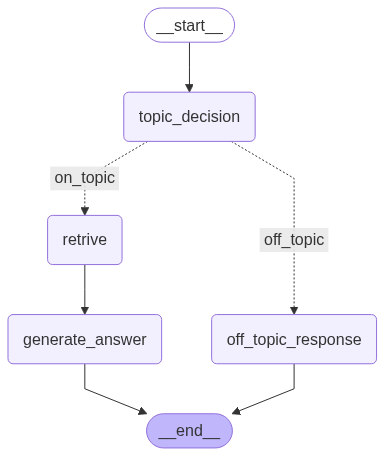

In [31]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [36]:
graph.invoke(input={
    "messages": [HumanMessage(content="Who is the owner and what are the timings?")]
})

TypeError: argument 'text': 'HumanMessage' object cannot be converted to 'PyString'